In [2]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [3]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [4]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [5]:
x=[]
y=[]
labels={}
i=0
for ind, row in data.iterrows():
    if row['label'] not in labels:
        labels[row['label']]=i
        i+=1
    y.append(labels[row['label']])
    x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [6]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x = []
test_y=[]
test_labels={}
i=0
for ind, row in test_data.iterrows():
    if row['label'] not in test_labels:
        test_labels[row['label']]=i
        i+=1
    test_y.append(test_labels[row['label']])
    test_x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [9]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

### Create vectors

In [ ]:
x_vec = encode_deepmoji(x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [ ]:
test_x_vec = encode_deepmoji(test_x)

In [ ]:
tokens = [v for k,v in label2emotion.items()]
tokens

In [ ]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [ ]:
idx = np.r_[np.random.choice(idx_others,6000),np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [ ]:
idx.shape

In [ ]:
deepmoji_train = x_vec[idx]
y_train = y[idx]

### Models

In [ ]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='macro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens)

### Logistic Regression

In [ ]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

In [ ]:
print_metrics(LR.predict(deepmoji_test))

In [ ]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

In [ ]:
LR = LogisticRegression(random_state=0).fit(x_vec, y) 
print_metrics(LR.predict(deepmoji_test))

### Naive Bayes

In [ ]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

     others       0.96      0.74      0.84      4677
      happy       0.01      0.02      0.01       284
        sad       0.05      0.09      0.06       298
      angry       0.02      0.06      0.03       250

avg / total       0.82      0.63      0.71      5509

Accuracy: 0.6349609729533491
Precision: 0.2599238454767276
Recall: 0.2256137621252669
F1 score:  0.23494155756076057
Confusion matrix, without normalization
[[3452  431  326  468]
 [  68    6   11  199]
 [  25  242   26    5]
 [  42   19  175   14]]


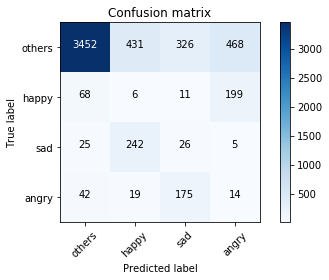

In [57]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(deepmoji_train, y_train)
print_metrics(mc_svm_ovo.predict(deepmoji_test))

### SVM One vs Rest

In [ ]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(deepmoji_train, y_train)
print_metrics(mc_svm_ovr.predict(deepmoji_test))